In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import math

Using TensorFlow backend.


In [2]:
img_width = 150
img_height = 150

epochs = 50
batch_size = 16

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

nb_train_samples = 3000
nb_validation_samples = 1000

In [3]:
import time

ti_bn_features = time.time()

model = applications.VGG19(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

'''
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L1002
if PIL version 1.1.3 interpolation = 'lanczos'
else interpolation = 'bicubic' 
''' 

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False)

nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

bnfeatures_train = model.predict_generator(
    generator, predict_size_train)

np.save('../data/output_convnet/VGG19_bnfeatures_train.npy', bnfeatures_train)


generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_validation_samples = len(generator.filenames)
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bnfeatures_val = model.predict_generator(  
     generator, predict_size_validation)

np.save('../data/output_convnet/VGG19_bnfeatures_val.npy', bnfeatures_val)


tf_bn_features = time.time()    
tt_bn_features = tf_bn_features - ti_bn_features
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
00:00:37


Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 2s 507us/step - loss: 1.6768 - acc: 0.3920 - val_loss: 1.2740 - val_acc: 0.6050
Epoch 2/50
3000/3000 [==============================] - 1s 318us/step - loss: 1.2480 - acc: 0.5740 - val_loss: 1.0651 - val_acc: 0.6630
Epoch 3/50
3000/3000 [==============================] - 1s 311us/step - loss: 1.0713 - acc: 0.6323 - val_loss: 0.9085 - val_acc: 0.7580
Epoch 4/50
3000/3000 [==============================] - 1s 293us/step - loss: 0.9757 - acc: 0.6760 - val_loss: 0.8401 - val_acc: 0.7550
Epoch 5/50
3000/3000 [==============================] - 1s 289us/step - loss: 0.9082 - acc: 0.6953 - val_loss: 0.8031 - val_acc: 0.7400
Epoch 6/50
3000/3000 [==============================] - 1s 287us/step - loss: 0.8395 - acc: 0.7240 - val_loss: 0.7244 - val_acc: 0.7950
Epoch 7/50
3000/3000 [==============================

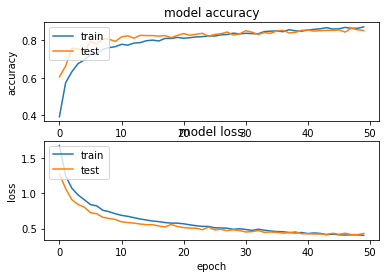

00:00:46


In [4]:
import os

ti_bn_train = time.time()

datagen_top = ImageDataGenerator(rescale=1./255)  

generator_top = datagen_top.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    interpolation = 'lanczos')  

nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  


train_data = np.load('../data/output_convnet/VGG19_bnfeatures_train.npy')

# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  

# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)



generator_top = datagen_top.flow_from_directory(  
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    interpolation = 'lanczos')  

nb_validation_samples = len(generator_top.filenames)  

validation_data = np.load('../data/output_convnet/VGG19_bnfeatures_val.npy')  

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)


# top model
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer=SGD(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))  

model.save_weights('../data/output_convnet/bn_VGG19_model.h5')  

(eval_loss, eval_accuracy) = model.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print()
print()
print("acc: {:.2f}%".format(eval_accuracy * 100))  
print("loss: {}".format(eval_loss))

plt.figure(1)  
   
# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

PATH_TO_OUTPUT = "../data/output_convnet"
plt.savefig(os.path.join(PATH_TO_OUTPUT, "bn_VGG19.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()

tf_bn_train = time.time()    
tt_bn_train = tf_bn_train - ti_bn_train
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

In [5]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/bn_VGG16_model.h5', mode='r')
print(list(hdf5_file))

['dense_1', 'dense_2', 'dropout_1', 'flatten_1']


In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input

Using TensorFlow backend.


In [2]:
# path to the model weights files.
# weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = '../data/output_convnet/bn_VGG16_model.h5'

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'train/'
validation_data_dir = 'validation/'

nb_train_samples = 3000
nb_validation_samples = 1000
epochs = 50
batch_size = 5 # con 5 funciona con 16 es imposible probar con 10
num_classes = 8

In [3]:
# build the VGG16 network
input_tensor = Input(shape=(img_width,img_height,3))
base_model = applications.VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
print("model loaded")

model loaded


In [4]:
base_model.output_shape[1:]

(4, 4, 512)

In [5]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(8, activation='softmax'))

In [6]:
import h5py
hdf5_file = h5py.File(top_model_weights_path, mode='r')
# print(len(hdf5_file))
print(list(hdf5_file))

['dense_1', 'dense_2', 'dropout_1', 'flatten_1']


In [7]:
for i, layer in enumerate(base_model.layers):
    print (i, layer.name, layer.output_shape)

0 input_1 (None, 150, 150, 3)
1 block1_conv1 (None, 150, 150, 64)
2 block1_conv2 (None, 150, 150, 64)
3 block1_pool (None, 75, 75, 64)
4 block2_conv1 (None, 75, 75, 128)
5 block2_conv2 (None, 75, 75, 128)
6 block2_pool (None, 37, 37, 128)
7 block3_conv1 (None, 37, 37, 256)
8 block3_conv2 (None, 37, 37, 256)
9 block3_conv3 (None, 37, 37, 256)
10 block3_conv4 (None, 37, 37, 256)
11 block3_pool (None, 18, 18, 256)
12 block4_conv1 (None, 18, 18, 512)
13 block4_conv2 (None, 18, 18, 512)
14 block4_conv3 (None, 18, 18, 512)
15 block4_conv4 (None, 18, 18, 512)
16 block4_pool (None, 9, 9, 512)
17 block5_conv1 (None, 9, 9, 512)
18 block5_conv2 (None, 9, 9, 512)
19 block5_conv3 (None, 9, 9, 512)
20 block5_conv4 (None, 9, 9, 512)
21 block5_pool (None, 4, 4, 512)


In [8]:
for i, layer in enumerate(top_model.layers):
    print (i, layer.name, layer.output_shape)

0 flatten_1 (None, 8192)
1 dense_1 (None, 256)
2 dropout_1 (None, 256)
3 dense_2 (None, 8)


In [9]:
top_model.load_weights("../data/output_convnet/bn_VGG19_model.h5")

In [10]:
model_total = Model(input= base_model.input, output= top_model(base_model.output))

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [11]:
for i, layer in enumerate(base_model.layers):
    print (i, layer.name, layer.output_shape)

0 input_1 (None, 150, 150, 3)
1 block1_conv1 (None, 150, 150, 64)
2 block1_conv2 (None, 150, 150, 64)
3 block1_pool (None, 75, 75, 64)
4 block2_conv1 (None, 75, 75, 128)
5 block2_conv2 (None, 75, 75, 128)
6 block2_pool (None, 37, 37, 128)
7 block3_conv1 (None, 37, 37, 256)
8 block3_conv2 (None, 37, 37, 256)
9 block3_conv3 (None, 37, 37, 256)
10 block3_conv4 (None, 37, 37, 256)
11 block3_pool (None, 18, 18, 256)
12 block4_conv1 (None, 18, 18, 512)
13 block4_conv2 (None, 18, 18, 512)
14 block4_conv3 (None, 18, 18, 512)
15 block4_conv4 (None, 18, 18, 512)
16 block4_pool (None, 9, 9, 512)
17 block5_conv1 (None, 9, 9, 512)
18 block5_conv2 (None, 9, 9, 512)
19 block5_conv3 (None, 9, 9, 512)
20 block5_conv4 (None, 9, 9, 512)
21 block5_pool (None, 4, 4, 512)


In [12]:
for i, layer in enumerate(top_model.layers):
    print (i, layer.name, layer.output_shape)

0 flatten_1 (None, 8192)
1 dense_1 (None, 256)
2 dropout_1 (None, 256)
3 dense_2 (None, 8)


In [13]:
for i, layer in enumerate(model_total.layers):
    print (i, layer.name, layer.output_shape)

0 input_1 (None, 150, 150, 3)
1 block1_conv1 (None, 150, 150, 64)
2 block1_conv2 (None, 150, 150, 64)
3 block1_pool (None, 75, 75, 64)
4 block2_conv1 (None, 75, 75, 128)
5 block2_conv2 (None, 75, 75, 128)
6 block2_pool (None, 37, 37, 128)
7 block3_conv1 (None, 37, 37, 256)
8 block3_conv2 (None, 37, 37, 256)
9 block3_conv3 (None, 37, 37, 256)
10 block3_conv4 (None, 37, 37, 256)
11 block3_pool (None, 18, 18, 256)
12 block4_conv1 (None, 18, 18, 512)
13 block4_conv2 (None, 18, 18, 512)
14 block4_conv3 (None, 18, 18, 512)
15 block4_conv4 (None, 18, 18, 512)
16 block4_pool (None, 9, 9, 512)
17 block5_conv1 (None, 9, 9, 512)
18 block5_conv2 (None, 9, 9, 512)
19 block5_conv3 (None, 9, 9, 512)
20 block5_conv4 (None, 9, 9, 512)
21 block5_pool (None, 4, 4, 512)
22 sequential_1 (None, 8)


In [14]:
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_1 is freezed
layer 1, block1_conv1 is trainable
layer 2, block1_conv2 is trainable
layer 3, block1_pool is trainable
layer 4, block2_conv1 is trainable
layer 5, block2_conv2 is trainable
layer 6, block2_pool is trainable
layer 7, block3_conv1 is trainable
layer 8, block3_conv2 is trainable
layer 9, block3_conv3 is trainable
layer 10, block3_conv4 is trainable
layer 11, block3_pool is trainable
layer 12, block4_conv1 is trainable
layer 13, block4_conv2 is trainable
layer 14, block4_conv3 is trainable
layer 15, block4_conv4 is trainable
layer 16, block4_pool is trainable
layer 17, block5_conv1 is trainable
layer 18, block5_conv2 is trainable
layer 19, block5_conv3 is trainable
layer 20, block5_conv4 is trainable
layer 21, block5_pool is trainable
layer 22, sequential_1 is trainable


In [17]:
# to non-trainable (weights will not be updated)
for layer in model_total.layers[:17]:
    layer.trainable = False

In [18]:
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_1 is freezed
layer 1, block1_conv1 is freezed
layer 2, block1_conv2 is freezed
layer 3, block1_pool is freezed
layer 4, block2_conv1 is freezed
layer 5, block2_conv2 is freezed
layer 6, block2_pool is freezed
layer 7, block3_conv1 is freezed
layer 8, block3_conv2 is freezed
layer 9, block3_conv3 is freezed
layer 10, block3_conv4 is freezed
layer 11, block3_pool is freezed
layer 12, block4_conv1 is freezed
layer 13, block4_conv2 is freezed
layer 14, block4_conv3 is freezed
layer 15, block4_conv4 is freezed
layer 16, block4_pool is freezed
layer 17, block5_conv1 is trainable
layer 18, block5_conv2 is trainable
layer 19, block5_conv3 is trainable
layer 20, block5_conv4 is trainable
layer 21, block5_pool is trainable
layer 22, sequential_1 is trainable


In [19]:
model_total.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy']) 

In [20]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [21]:
import time
# fine-tune the model

# añadir medidas de acc loss como el bottleneck

ti_ftuning = time.time()


historical_data = model_total.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    verbose = 1,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples)

tf_ftuning = time.time()
tt_ftuning = tf_ftuning - ti_ftuning
print(time.strftime("%H:%M:%S", time.gmtime(tt_ftuning)))

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=50, verbose=1, validation_data=<keras.pre..., validation_steps=1000, steps_per_epoch=600)`
  from ipykernel import kernelapp as app


Epoch 1/50
600/600 [==============================] - 117s 194ms/step - loss: 0.6129 - acc: 0.7907 - val_loss: 0.3479 - val_acc: 0.8740
Epoch 2/50
600/600 [==============================] - 115s 192ms/step - loss: 0.4509 - acc: 0.8417 - val_loss: 0.3249 - val_acc: 0.8860
Epoch 3/50
600/600 [==============================] - 115s 192ms/step - loss: 0.4132 - acc: 0.8600 - val_loss: 0.3571 - val_acc: 0.8750
Epoch 4/50
600/600 [==============================] - 115s 192ms/step - loss: 0.3650 - acc: 0.8730 - val_loss: 0.3186 - val_acc: 0.8820
Epoch 5/50
600/600 [==============================] - 115s 192ms/step - loss: 0.3345 - acc: 0.8837 - val_loss: 0.2942 - val_acc: 0.8960
Epoch 6/50
600/600 [==============================] - 115s 192ms/step - loss: 0.3178 - acc: 0.8863 - val_loss: 0.3779 - val_acc: 0.8720
Epoch 7/50
600/600 [==============================] - 115s 192ms/step - loss: 0.2972 - acc: 0.8937 - val_loss: 0.2712 - val_acc: 0.8960
Epoch 8/50
600/600 [============================

In [24]:
historical_data

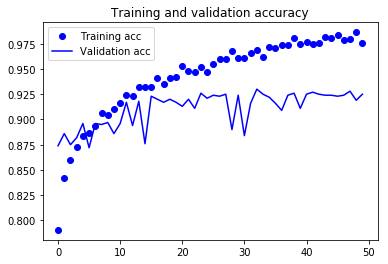

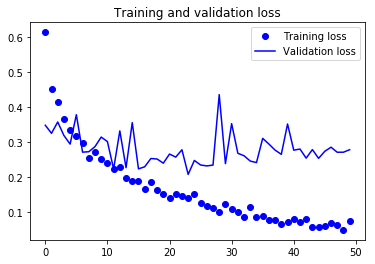

In [25]:
import matplotlib.pyplot as plt
PATH_TO_DF = "../data/output_convnet"

acc = historical_data.history['acc']
val_acc = historical_data.history['val_acc']
loss = historical_data.history['loss']
val_loss = historical_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
model_total.save_weights('../data/output_convnet/ft_VGG19_model.h5')

In [26]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/ft_VGG19_model.h5', mode='r')
print(list(hdf5_file))

['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool', 'input_1', 'sequential_1']


In [31]:
# build the VGG16 network
# input_tensor = Input(shape=(img_width,img_height,3))
model_base_pred = applications.VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)  
print("model base for predition loaded")

# build top model  
model_top_pred = Sequential()  
model_top_pred.add(Flatten(input_shape=model_base_pred.output_shape[1:]))  
model_top_pred.add(Dense(256, activation='relu'))  
model_top_pred.add(Dropout(0.5))  
model_top_pred.add(Dense(8, activation='softmax'))
print()
print("model top for predition loaded")

model base for predition loaded

model top for predition loaded


In [32]:
model_total_pred = Model(input= model_base_pred.input, output= model_top_pred(model_base_pred.output))

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """Entry point for launching an IPython kernel.


In [33]:
for i, layer in enumerate(model_total_pred.layers):
    print (i, layer.name, layer.output_shape)

0 input_1 (None, 150, 150, 3)
1 block1_conv1 (None, 150, 150, 64)
2 block1_conv2 (None, 150, 150, 64)
3 block1_pool (None, 75, 75, 64)
4 block2_conv1 (None, 75, 75, 128)
5 block2_conv2 (None, 75, 75, 128)
6 block2_pool (None, 37, 37, 128)
7 block3_conv1 (None, 37, 37, 256)
8 block3_conv2 (None, 37, 37, 256)
9 block3_conv3 (None, 37, 37, 256)
10 block3_conv4 (None, 37, 37, 256)
11 block3_pool (None, 18, 18, 256)
12 block4_conv1 (None, 18, 18, 512)
13 block4_conv2 (None, 18, 18, 512)
14 block4_conv3 (None, 18, 18, 512)
15 block4_conv4 (None, 18, 18, 512)
16 block4_pool (None, 9, 9, 512)
17 block5_conv1 (None, 9, 9, 512)
18 block5_conv2 (None, 9, 9, 512)
19 block5_conv3 (None, 9, 9, 512)
20 block5_conv4 (None, 9, 9, 512)
21 block5_pool (None, 4, 4, 512)
22 sequential_3 (None, 8)


In [34]:
# cargamos los pesos anteriormente obtenidos en el entrenamiento
model_total_pred.load_weights("../data/output_convnet/ft_VGG19_model.h5")

In [35]:
test_data_dir = 'test/'
batch_size_test = 5 # probamos con esto

test_convnet = ImageDataGenerator(rescale=1. / 255)

test_generator = test_convnet.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle =False,
    class_mode='categorical')

cat_dict = test_generator.class_indices

inverse_coding = {v: k for k, v in cat_dict.items()}

Found 1000 images belonging to 8 classes.


In [36]:
import os

test_data_dir = "test/"

# listado del train
img_test_real = [] # listado de las imagenes pareado con img_cat_real
img_cat_real = [] # categorias de las imagenes


img_cat_pred = [] # elementos predichos por la convnet

img_folder = sorted([folder for folder in os.listdir(test_data_dir)
                  if os.path.isdir(os.path.join(test_data_dir, folder))])

for index_folder, category in enumerate(img_folder):
    
    folder = os.path.join(test_data_dir, category)

    for index_img, img in enumerate(os.listdir(folder)):
        
        if img.endswith(".tif"): # just in case there are other kind of files like .db
            img_test_real.append(os.path.join(folder, img))
            img_cat_real.append(img_folder[index_folder])

    print("Category {0:s} has {1:d} images.".format(category, index_img+1))

Category 01_TUMOR has 130 images.
Category 02_STROMA has 124 images.
Category 03_COMPLEX has 132 images.
Category 04_LYMPHO has 112 images.
Category 05_DEBRIS has 117 images.
Category 06_MUCOSA has 127 images.
Category 07_ADIPOSE has 131 images.
Category 08_EMPTY has 127 images.


In [37]:
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input

In [38]:
for index, img_path in enumerate(img_test_real):
    
    if not index % 100:
        print("image {0:d} processed".format(index))
        
    # pre process
    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    x = x / 255
    
    # prediction
    x = model_total_pred.predict(x)
    
    # label
    label = inverse_coding[np.argmax(x)]
    
    # store the label
    img_cat_pred.append(label)
    

image 0 processed
image 100 processed
image 200 processed
image 300 processed
image 400 processed
image 500 processed
image 600 processed
image 700 processed
image 800 processed
image 900 processed


In [ ]:
img_cat_pred_arr = np.array(img_cat_pred)
img_cat_real_arr = np.array(img_cat_real)

In [ ]:
from sklearn.metrics import confusion_matrix
ft_conf_mat = confusion_matrix(img_cat_real_arr,img_cat_pred_arr)

In [ ]:
ft_conf_mat

In [ ]:
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)

In [ ]:
PATH_TO_IMG = "../data/input_dataset"
class_names = sorted([folder for folder in os.listdir(PATH_TO_IMG)
                      if os.path.isdir(os.path.join(PATH_TO_IMG, folder))])

In [ ]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plot_confusion_matrix(ft_conf_mat, classes=class_names, title='Confusion matrix')

fig.add_subplot(1,2,2)
plot_confusion_matrix(ft_conf_mat, classes=class_names, normalize=True, title='Confusion matrix')

plt.savefig(os.path.join(PATH_TO_DF, "ft_confmat_VGG16.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()